In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
df=pd.read_csv(r"D:\VIT_Sem_3_Project\cardio_(70K instances).csv")

### 1. Data preprocessing

In [122]:
df.head() 

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [123]:
df.shape

(70000, 13)

In [124]:
## 1. Convert age in years
df['age']=(df['age']/365).round()

In [125]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [126]:
df = df[(df['ap_hi'] >= 80) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 50) & (df['ap_lo'] <= 150)]

df = df[df['weight'] < 200]
df = df[df['height'] < 250]


### Feature Engineering

In [127]:
# Create a derived column representing body mass index named as 'bmi'
df['bmi'] = df['weight'] / (df['height']/100)**2

# Create a derived column for pulse pressure 
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

# a column for BP Category 
def bp_category(row):
    if row['ap_hi'] < 120:
        return 0   # normal
    elif row['ap_hi'] < 140:
        return 1   # elevated
    else:
        return 2   # high

## creating a column named as BP category.
df['bp_cat'] = df.apply(bp_category, axis=1)


In [128]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure,bp_cat
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50,2
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50,2
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40,0


In [129]:
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
            'pulse_pressure', 'bp_cat'] 
target = 'cardio'
print("Final Dataset Shape: ",df.shape) 

Final Dataset Shape:  (68718, 16)


In [130]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y) 


In [131]:
### performing standard scaling...
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### Model Fitting 

#### 1. Logistic regression

In [132]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### 2. XGBoost

In [133]:
# pip install xgboost

In [134]:
import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=600)
xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [135]:
### Performance measure 

from sklearn.metrics import roc_auc_score, f1_score

print("LR AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_s)[:,1]))
print("XGB AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


LR AUC: 0.7859994578916527
XGB AUC: 0.7986957590663639


#### 3. Calibrated model

In [136]:
from sklearn.calibration import CalibratedClassifierCV

cal_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
cal_xgb.fit(X_train, y_train) 


,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [137]:
from sklearn.metrics import roc_auc_score

cal_probs = cal_xgb.predict_proba(X_test)[:,1]
cal_auc = roc_auc_score(y_test, cal_probs)

print("Calibrated XGB AUC:", cal_auc)


Calibrated XGB AUC: 0.7988790525950351


In [157]:
## Disease prediction

cal_pred = (cal_probs >= 0.5).astype(int)
cal_pred

array([1, 0, 1, ..., 1, 0, 1], shape=(13744,))

In [138]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'pulse_pressure', 'bp_cat'],
      dtype='object')

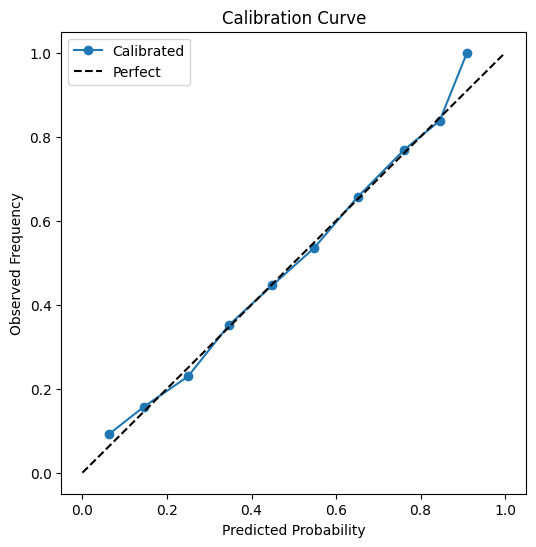

In [56]:
#### Calibration plot

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fraction_pos, mean_pred = calibration_curve(y_test, cal_probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(mean_pred, fraction_pos, marker='o', label='Calibrated')
plt.plot([0,1],[0,1], 'k--', label='Perfect')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [58]:
### Brier Score
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, cal_probs)
print("Brier Score:", brier) 


Brier Score: 0.18150466279241417


## SHAP ( SHapley Additive exPlanations)

PermutationExplainer explainer: 13745it [44:23,  5.16it/s]                                                             


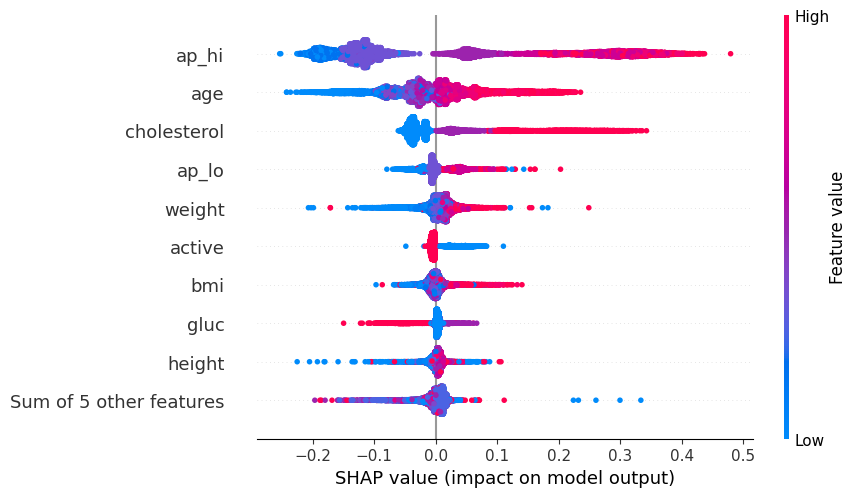

In [67]:
# pip install shap

import shap

# Make callable prediction function
model_fn = lambda x: xgb.predict_proba(x)[:,1]

explainer = shap.Explainer(model_fn, X_train) 
shap_values = explainer(X_test) 

shap.plots.beeswarm(shap_values) 



### Local SHAP Per patient

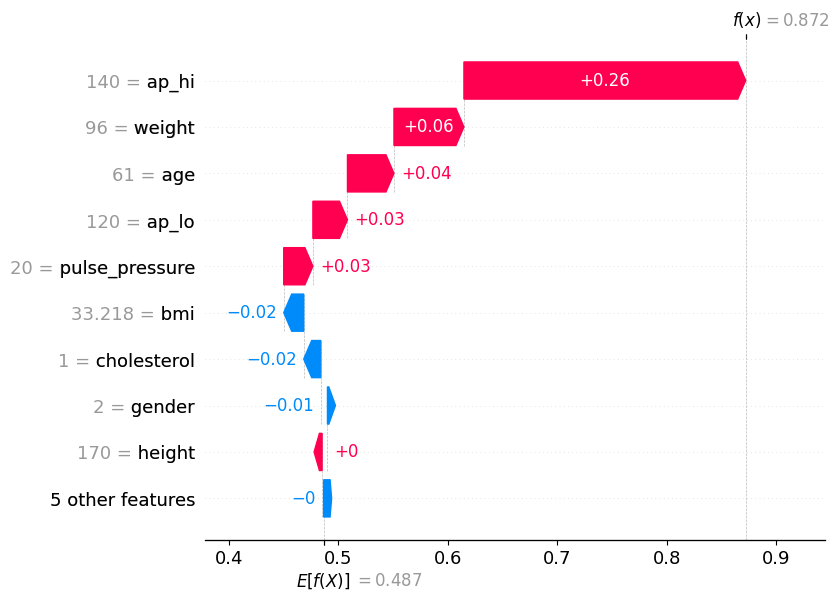

In [68]:
# Pick first patient
i = 0
shap.plots.waterfall(shap_values[i], max_display=10)


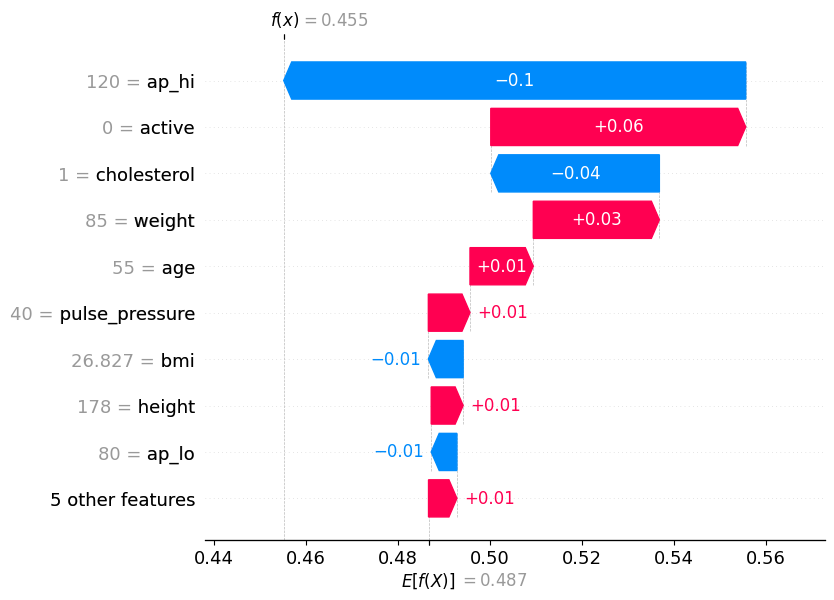

In [71]:
# Pick fifth patient
i = 5
shap.plots.waterfall(shap_values[i], max_display=10)


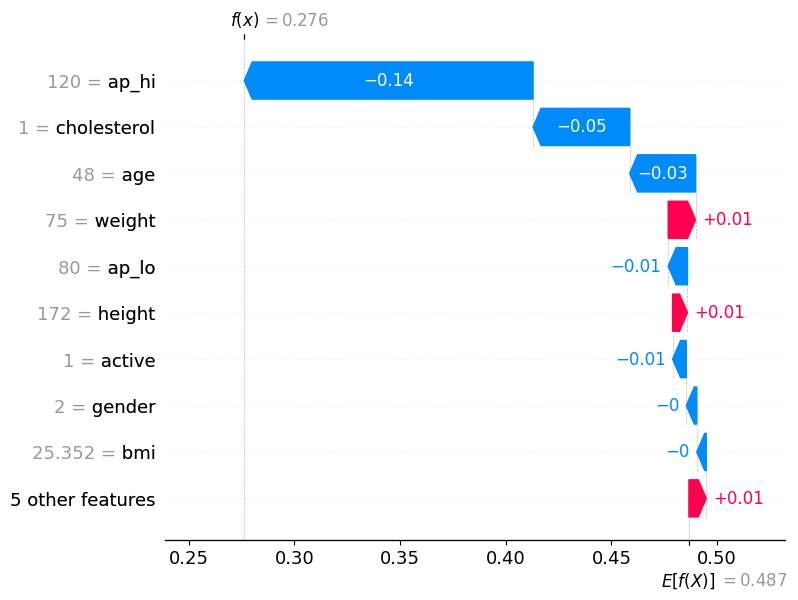

In [72]:
# Pick 1oth patient
i = 10
shap.plots.waterfall(shap_values[i], max_display=10)


### SUBGROUP ANALYSIS

In [158]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

# Create a working copy with predictions
test_df = X_test.copy()
test_df["y_true"] = y_test.values
test_df["prob"] = cal_probs
test_df["pred"] = (cal_probs >= 0.5).astype(int)

# Age group classification
test_df["age_group"] = test_df["age"].apply(lambda x: "<45" if x < 45 else ">=45")

In [166]:
# Metric function
def subgroup_metrics(df, name):
    auc = roc_auc_score(df["y_true"], df["prob"])
    acc = accuracy_score(df["y_true"], df["pred"])
    f1 = f1_score(df["y_true"], df["pred"])
    prec = precision_score(df["y_true"], df["pred"])
    rec = recall_score(df["y_true"], df["pred"])

    print(f"\n ### {name}  ")
    print("AUC:", round(auc,3))
    print("Accuracy:", round(acc,3))
    print("F1:", round(f1,3))
    print("Precision:", round(prec,3))
    print("Recall:", round(rec,3))


# AGE SUBGROUPS
df_young = test_df[test_df["age_group"] == "<45"]
df_old   = test_df[test_df["age_group"] == ">=45"]

subgroup_metrics(df_young, "Age < 45")
subgroup_metrics(df_old,   "Age ≥ 45")


 ### Age < 45  
AUC: 0.814
Accuracy: 0.825
F1: 0.666
Precision: 0.811
Recall: 0.565

 ### Age ≥ 45  
AUC: 0.783
Accuracy: 0.718
F1: 0.722
Precision: 0.75
Recall: 0.697


In [167]:
## GENDER SUBGROUPS
# gender: 1=female, 2=male
df_male   = test_df[test_df["gender"] == 2]
df_female = test_df[test_df["gender"] == 1]

subgroup_metrics(df_male,   "Male")
subgroup_metrics(df_female, "Female")



 ### Male  
AUC: 0.8
Accuracy: 0.74
F1: 0.729
Precision: 0.769
Recall: 0.693

 ### Female  
AUC: 0.798
Accuracy: 0.73
F1: 0.712
Precision: 0.746
Recall: 0.681


In [168]:

# Summary Table
rows = []

def collect(df, name):
    auc = roc_auc_score(df["y_true"], df["prob"])
    acc = accuracy_score(df["y_true"], df["pred"])
    f1 = f1_score(df["y_true"], df["pred"])
    prec = precision_score(df["y_true"], df["pred"])
    rec = recall_score(df["y_true"], df["pred"])
    rows.append([name, auc, acc, f1, prec, rec])


collect(df_young, "Age < 45")
collect(df_old,   "Age ≥ 45")
collect(df_male,  "Male")
collect(df_female,"Female")

sub_df = pd.DataFrame(rows, columns=["Group","AUC","Accuracy","F1","Precision","Recall"])
print("\n\n SUBGROUP SUMMARY TABLE ")
sub_df




 SUBGROUP SUMMARY TABLE 


,Group,AUC,Accuracy,F1,Precision,Recall
0,Age < 45,0.814358,0.825013,0.666012,0.811005,0.565000
1,Age ≥ 45,0.782828,0.718414,0.722273,0.749653,0.696823
2,Male,0.800188,0.740230,0.728899,0.768983,0.692786
3,Female,0.798154,0.729881,0.711836,0.745572,0.681021


# Spatial Analysis of CVD

# Finding Top 5 and Bottom 5 states by cv_rank and iqr_rank

In [1]:
import pandas as pd
rank_file= pd.read_csv(r'cvd_rank_file.csv')
rank_file.head()

,States,2018,2019,2020,2021,2022,Latitude,Longitude,Population,Unnamed: 9,mean (x_bar),sd,cv,cv_rank,Q1,Q3,iqr,iqr_rank
0,Andaman and Nicobar Islands,0,0,0,0,0,12.500000,92.750000,404000,NaN,0.0,0.000000,0.000000,1,0,0,0,1.5
1,Andhra Pradesh,9585,9697,4828,6353,11397,15.893910,80.764801,53402000,NaN,8372.0,2693.228360,32.169474,12,6353,9697,3344,29.0
2,Arunachal Pradesh,268,171,140,172,295,28.213182,94.396770,1580000,NaN,209.2,67.916861,32.465039,13,171,268,97,6.0
3,Assam,1548,1454,1071,793,913,26.200603,92.937576,36159000,NaN,1155.8,331.854938,28.712142,9,913,1454,541,16.0
4,Bihar,660,990,463,1816,11125,25.096073,85.313118,129205000,NaN,3010.8,4565.330404,151.631806,33,660,1816,1156,20.0


## Top 5 states by cv_rank

In [13]:
top_5_states_cv_rank=rank_file.sort_values(by='cv_rank').head(5)[['States','cv_rank']]
top_5_states_cv_rank

,States,cv_rank
0,Andaman and Nicobar Islands,1
13,Jammu and Kashmir,2
15,Karnataka,3
9,Goa,4
29,Tamil Nadu,5


## Bottom 5 states by cv_rank

In [14]:
bottom_5_states_cv_rank=rank_file.sort_values(by='cv_rank',ascending=False).head(5)[['States','cv_rank']]
bottom_5_states_cv_rank

,States,cv_rank
17,Lakshadweep,35
30,Telangana,34
4,Bihar,33
22,Mizoram,32
8,Delhi,31


## Top 5 States by iqr_rank

In [15]:
top_5_states_iqr_rank=rank_file.sort_values(by='iqr_rank').head(5)[['States','iqr_rank']]
top_5_states_iqr_rank

,States,iqr_rank
0,Andaman and Nicobar Islands,1.5
17,Lakshadweep,1.5
28,Sikkim,3.0
22,Mizoram,4.0
5,Chandigarh,5.0


## Bottom 5 states by iqr_rank

In [16]:
bottom_5_states_iqr_rank=rank_file.sort_values(by='iqr_rank',ascending=False).head(5)[['States','iqr_rank']]
bottom_5_states_iqr_rank

,States,iqr_rank
34,West Bengal,35.0
27,Rajasthan,34.0
32,Uttar Pradesh,33.0
18,Madhya Pradesh,32.0
19,Maharashtra,31.0
